# Для курса "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

In [553]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.cluster import KMeans

from lightgbm import LGBMRegressor

%matplotlib inline

# 1. Чтение данных

In [554]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


13700

In [555]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [556]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [557]:
X.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B


## 1. Минимальный EDA

Делайем EDA не просто так, а для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### 1.1 Выбросы

In [558]:
X.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

**Rooms**

In [559]:
X['Rooms'].value_counts()

# > 6 комнат, = площадь делим на 20

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [560]:
X['KitchenSquare'].value_counts().sort_values()

# Площадь < 3
# Площадь > 1000

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [561]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [562]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [563]:
(X['Floor'] > X['HouseFloor']).sum()

1825

**HouseYear**

In [564]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [565]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [566]:
X['Helthcare_2'].value_counts().sort_values()

6      99
4     288
5     388
2    1158
3    1670
1    2183
0    4214
Name: Helthcare_2, dtype: int64

### Заполнение NaN

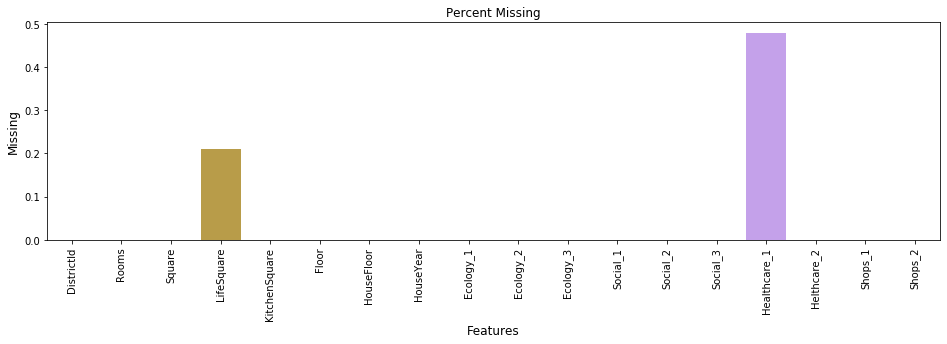

In [567]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [568]:
X.DistrictId.nunique()

205

In [569]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '13': 97,
 '47': 97,
 '99': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '128': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '129': 43,
 '124': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '5': 34,
 '56': 34,
 '32': 34,
 '103': 33,
 '123': 32,
 '19': 31,
 '33': 31,
 '80': 31,
 '83': 31,
 '130': 29,
 '138': 29,
 '69': 29,
 '64': 28,
 '70': 27,
 '87': 27,
 '108': 27,
 '86': 

# 2. Очистка данных

In [570]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = round(X['Square'] / 20) #Поделим площадь квартиры на 20
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = X.loc[X['KitchenSquare'] < 3, 'Square'] / (X.loc[X['KitchenSquare'] < 3, 'Rooms'] + 1)
        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = X['Square'] / 2
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] > 60, 'HouseFloor'] = round(X.loc[X['HouseFloor'] > 60, 'HouseFloor'] / 10)
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = int(2011)
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
                      
        
        return X
        

In [571]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [572]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,B,...,33,7976,5,0,11,B,0,0,0,0
15053,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,B,...,46,10309,1,1,16,B,0,0,0,0
4765,53,2.0,44.947953,29.197612,14.982651,8.0,12.0,1968,0.049637,B,...,34,7759,0,1,3,B,0,0,0,0
5809,58,2.0,53.352981,52.731512,9.000000,8.0,17.0,1977,0.437885,B,...,23,5735,3,0,5,B,0,0,0,0
10783,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,B,...,35,5776,1,2,4,B,0,0,0,0


# 3. Feature engineering

In [573]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.helthcare_district = None # здоровье района
        self.district_price = None # средняя стоимость квадратного метра в районе
        self.district_year_price = None # средняя стоимость квадратного метра в районе по году постройки
        self.district_shops = None # наличие магазинов, торговых центров в районе
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.district_year_price = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'DistrictYearPrice'})
            self.district_price = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'DistrictPrice'})
            self.district_shops = df.groupby(['DistrictId', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'DistrictShops'})
            
        ## square
        if y is not None:
            df['Price'] = y.values
            
            
            
        ## helthcare
        if y is not None:
            df['Price'] = y.values
            self.helthcare_district = df.groupby(['Helthcare_2', 'DistrictId'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'HelthcareDistrict'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.helthcare_district is not None:
            X = X.merge(self.helthcare_district, on=['Helthcare_2', 'DistrictId'], how='left')
        if self.district_price is not None:
            X = X.merge(self.district_price, on=['DistrictId'], how='left')
            X['DistrictPrice'] = X['DistrictPrice'] / X['Square']
        if self.district_year_price is not None:
            X = X.merge(self.district_year_price, on=['DistrictId', 'HouseYear'], how='left')
            X['DistrictYearPrice'] = X['DistrictYearPrice'] / X['Square']
        if self.district_shops is not None:
            X = X.merge(self.district_shops, on=['DistrictId', 'Shops_1'], how='left')
            X['DistrictShops'] = X['DistrictShops'] / X['Square']
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        X['floor_first_cat'] = 0
        X['floor_last_cat'] = 0
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        
        X.loc[X['Floor'] == 1, 'floor_first_cat'] = 1  
        X.loc[X['Floor'] == X['HouseFloor'], 'floor_last_cat'] = 1
            
        return X
         
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X 
            
    

In [574]:
features = FeatureGenetator()

features.fit(X, y)
X = features.transform(X)
X_final = features.transform(X_final)

In [575]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,floor_first_cat,floor_last_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,LifeSquareToSquare,HelthcareDistrict,DistrictPrice,DistrictYearPrice,DistrictShops
0,35,2.0,47.981561,29.442751,6.000000,7.0,9.0,1969,0.089040,1,...,0,0,3.0,NaN,181784.539475,NaN,NaN,NaN,NaN,NaN
1,41,3.0,65.683640,40.049543,8.000000,7.0,9.0,1978,0.000070,1,...,0,0,3.0,300009.450063,181784.539475,4567.491245,210694.850106,3207.721900,4142.550140,2620.727381
2,53,2.0,44.947953,29.197612,14.982651,8.0,12.0,1968,0.049637,1,...,0,0,3.0,263206.223152,181784.539475,4915.149522,255009.423672,5472.524984,4702.267772,5673.438010
3,58,2.0,53.352981,52.731512,9.000000,8.0,17.0,1977,0.437885,1,...,0,0,3.0,166809.665642,181784.539475,3291.591637,147727.042421,2840.664212,2467.690024,2495.371619
4,99,1.0,39.649192,23.776169,7.000000,11.0,12.0,1976,0.012339,1,...,0,0,3.0,158539.052715,179775.801839,3788.892642,186983.021586,4510.285271,3928.077026,4715.935241


In [576]:
remain_features = [
                    'Rooms', 
                   'Square', 
                   'LifeSquare', 
                   'KitchenSquare', 
                   'Floor', 
                   'Ecology_1', 
                   'Social_1', 
                   'Shops_1',
                   'HouseFloor', 
                   'HouseYear',  
                  'DistrictId_count',
                  'MedPriceByDistrict',
                   'HelthcareDistrict', 
                   'DistrictPrice',
                   'DistrictShops'
                  ]

X = X[remain_features]
X_final = X_final[remain_features]

In [577]:
X.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,Ecology_1,Social_1,Shops_1,HouseFloor,HouseYear,DistrictId_count,MedPriceByDistrict,HelthcareDistrict,DistrictPrice,DistrictShops
0,2.0,47.981561,29.442751,6.000000,7.0,0.089040,33,11,9.0,1969,5.0,NaN,NaN,NaN,NaN
1,3.0,65.683640,40.049543,8.000000,7.0,0.000070,46,16,9.0,1978,87.0,300009.450063,210694.850106,3207.721900,2620.727381
2,2.0,44.947953,29.197612,14.982651,8.0,0.049637,34,3,12.0,1968,174.0,263206.223152,255009.423672,5472.524984,5673.438010
3,2.0,53.352981,52.731512,9.000000,8.0,0.437885,23,5,17.0,1977,179.0,166809.665642,147727.042421,2840.664212,2495.371619
4,1.0,39.649192,23.776169,7.000000,11.0,0.012339,35,4,12.0,1976,97.0,158539.052715,186983.021586,4510.285271,4715.935241


# 4. Модель

In [578]:
model = LGBMRegressor(max_depth=7,
                     min_samples_leaf=3,
                     n_estimators=300,
                     random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))

# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.738 +- 0.017


In [579]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=3,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

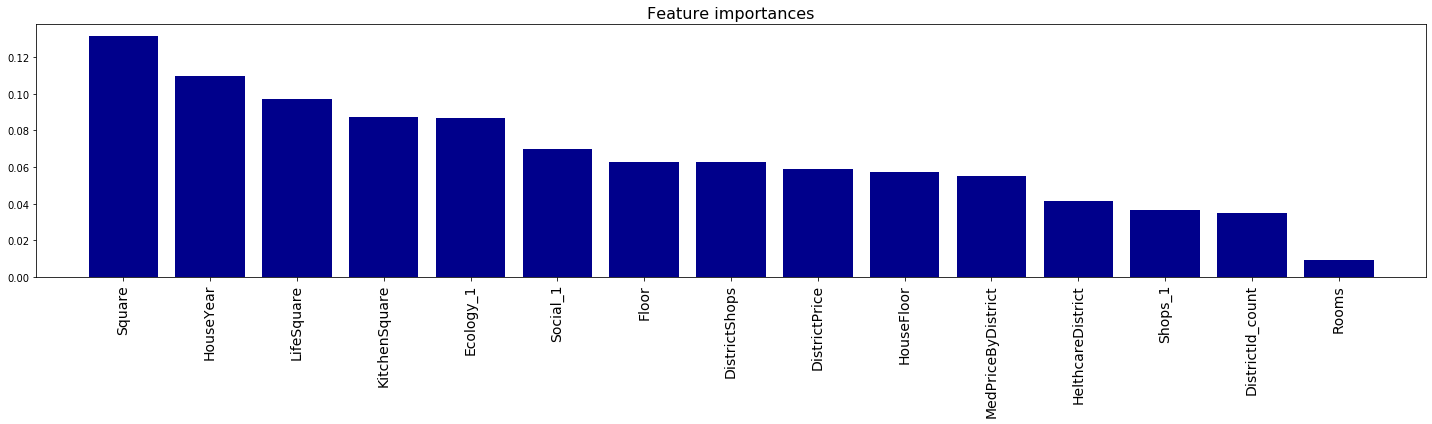

In [580]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [581]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,150966.496232
1,15856,240817.766387
2,5480,184873.523212
3,15664,311286.554507
4,14275,144568.241125


In [582]:
preds_final.shape

(5000, 2)